## Multi-generation climate model inter-comparison

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from various model generations from 1990-2019 and [`xskillscore`](https://github.com/raybellwaves/xskillscore) to calculate model skill with respect to NCEP Reanalysis 

### Note: update xskillscore by running
```bash
pip install git+https://github.com/bradyrx/xskillscore@skipna_functionality --upgrade
```
in a Jupyterlab terminal to enable the `skipna` option so that weights with NaNs in them (e.g. by applying a mask from `regionmask`) can work properly with `xskillscore`.

You will probably need to restart your kernel for the upgrade to `xskillscore` to kick in (you can check by typing `xs.mae(` and `Shift+Tab` in a code cell to see if the `skipna=False` flag shows up).

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Data catalogs

In [2]:
col_dict = {}
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col_dict["CMIP6"] = col
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

In [3]:
col = intake.open_esm_datastore("../catalogs/adhoc-ipcc-ar.json")
col_dict["pre-CMIP6"] = col
col

adhoc-ipcc-ar-ESM Collection with 44 entries:
	> 3 mip_id(s)

	> 1 activity_id(s)

	> 12 institution_id(s)

	> 12 source_id(s)

	> 1 experiment_id(s)

	> 1 member_id(s)

	> 1 table_id(s)

	> 3 variable_id(s)

	> 44 zstore(s)

In [4]:
mip_ids = ['FAR', 'SAR', 'TAR', 'CMIP6']
mip_catalog_dict = {}
for mip_id in mip_ids:
    if mip_id == 'CMIP6':
        mip_catalog_dict[mip_id] = "CMIP6"
    else:
        mip_catalog_dict[mip_id] = "pre-CMIP6"
mip_catalog_dict

{'FAR': 'pre-CMIP6', 'SAR': 'pre-CMIP6', 'TAR': 'pre-CMIP6', 'CMIP6': 'CMIP6'}

## The task at hand

- Loop through the `source_id` for `experiment_id == 'historical'`
- For each model:
    - select only a single ensemble member (at least for now)
    - Take a slice `time=slice('1981', '2010')` and compute time average over that slice (date range consistent with the long-term climatology of the NCEP reanalysis, to which we are comparing
    - Regrid the `tas` data to a common grid
    - drop redundant variables (like "height: 2m")
    - concatenate to ensemble dataset along `ensemble` dimension

### Defining a regridding function

In [5]:
# Choose how much to coarsen data
coarsen_size = 2

# Define the common target grid axes
dlon, dlat = 1., 1.
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90.+dlat/2., 90., dlat)),
                     'lon': (['lon'], np.arange(0.+dlon/2., 360., dlon)),})

# Regridding function
def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [6]:
Rearth = 6.378E6   # radius of Earth in meters
# a DataArray that gives grid cell areas on the lat/lon grid (in units of m^2)
area = (np.deg2rad(dlat)*Rearth) * (np.deg2rad(dlon)*Rearth*np.cos(np.deg2rad(ds_out.lat))) * xr.ones_like(ds_out.lon)

# coarsen
area = area.coarsen({'lat': coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [7]:
#varnames = ['tas','psl','pr','uas','vas']
varnames = ['tas', 'pr']
time_slice = slice('1981', '2010') # date range consistent with NCEP reanalysis long-term-mean

In [8]:
# For converting units for precip output
cm_to_m = 1.e-2
rho_water = 1.e3
day_in_s = (24.*60.*60.)

In [9]:
ds_dict = {}

for mip_id in tqdm(mip_ids):
    ds_dict[mip_id] = {}
    for varname in varnames:
        
        col = col_dict[mip_catalog_dict[mip_id]]
        cat = col.search(experiment_id='historical', 
                         table_id='Amon', 
                         variable_id=varname,
                         member_id='r1i1p1f1'  # choose first ensemble member only (for now)
                        )

        dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

        ds_dict[mip_id][varname] = {}
        for key, ds in dset_dict.items():
            if (mip_catalog_dict[mip_id] == 'pre-CMIP6') and (mip_id != key.split(".")[-1]): continue
            
            # rename spatial dimensions if necessary
            if ('longitude' in ds.dims) and ('latitude' in ds.dims):
                ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
            ds = xr.decode_cf(ds) # Need this temporarily because setting 'decode_times': True appears broken
            ds = ds.squeeze() # get rid of member_id (for now)
            
            # take long-term mean
            timeave = ds.sel(time=time_slice).mean(dim='time')
            
            # modify pre-CMIP6 chunks
            if mip_catalog_dict[mip_id] == 'pre-CMIP6':
                timeave = timeave.chunk({'lat':timeave['lat'].size, 'lon':timeave['lon'].size})
            
            # regrid to common grid
            ds_new = regrid_to_common(timeave[varname], ds_out)

            # Add metadata and apply various corrections
            if mip_catalog_dict[mip_id] == 'CMIP6':
                # Correct MCM-UA precipitation due to broken units (Ron Stouffer, personal communication)
                if ('MCM-UA' in ds.attrs['parent_source_id']) and (varname == 'pr'):
                    # convert from cm/day to kg/m^2/s
                    ds_new *= (cm_to_m * rho_water / day_in_s)
                    
                # TEMPORARY FIX: Correct BCC-ESM1 and CanESM5 which inexplicably have latitude flipped
                if ("BCC-ESM1" in key) or ("CanESM5" in key):
                    ds_new['lat'].values = ds_new['lat'].values[::-1]

                ds_new.attrs['name'] = ds.attrs['source_id']
                
            else:
                # Maybe chance this at pre-processing stage?
                ds_new.attrs['name'] = ds.attrs['institution']
            
            # drop redundant variables (like "height: 2m")
            for coord in ds_new.coords:
                if coord not in ['lat','lon']:
                    ds_new = ds_new.drop(coord)

            # Add ensemble as new dimension
            ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)

            # We should keep the metadata!!!
            ds_new.attrs['mip_id'] = mip_id
            ds_new = ds_new.coarsen({'lat': coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()
            
            ds_dict[mip_id][varname][key] = ds_new  # add this to the dictionary

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)
Reuse existing file: bilinear_40x48_180x360_peri.nc
Reuse existing file: bilinear_24x36_180x360_peri.nc
Reuse existing file: bilinear_72x96_180x360_peri.nc
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)
Reuse existing file: bilinear_40x48_180x360_peri.nc
Reuse existing file: bilinear_24x36_180x360_peri.nc
Reuse existing file: bilinear_72x96_180x360_peri.nc
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.mip_id'

--> There will be 16 group(s)
Reuse existing file: bilinear_48x96_180x360_peri.nc
Reuse existing file: bilinear_32x64_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x3

In [10]:
# Create a single dictionary whose keys are the MIP id
#  Each item in the dict will be a single xr.Dataset combining all data from each MIP generation
ens_dict = {}
for mip_id in mip_ids:
    mipdataset = xr.Dataset()
    for varname in varnames:
        vardataarray = xr.concat([ds for name, ds in ds_dict[mip_id][varname].items()], dim='ensemble')
        mipdataset[varname] = vardataarray
    mipdataset.attrs['name'] = mip_id
    
    ensmean = mipdataset.mean(dim='ensemble', skipna=True)
    mipdataset = xr.concat([ensmean.expand_dims({'ensemble': np.array(['ens-mean'])}), mipdataset], dim='ensemble')
    ens_dict[mip_id] = mipdataset
ens_dict

{'FAR': <xarray.Dataset>
 Dimensions:   (ensemble: 4, lat: 90, lon: 180)
 Coordinates:
   * lon       (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * ensemble  (ensemble) object 'ens-mean' 'GFDL' 'GISS' 'UKTR'
 Data variables:
     tas       (ensemble, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
     pr        (ensemble, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>,
 'SAR': <xarray.Dataset>
 Dimensions:   (ensemble: 9, lat: 90, lon: 180)
 Coordinates:
   * lon       (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
   * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
   * ensemble  (ensemble) object 'ens-mean' 'CCCma' ... 'MPIfM' 'NCAR'
 Data variables:
     tas       (ensemble, lat, lon) float64 dask.array<chunksize=(1, 90, 180), meta=np.ndarray>
     pr        (ensemble, lat, lon) float64 dask.array<chun

## Some 'observational' reference data to compare models against

We will use long-term mean climatology from NCEP reanalysis (because it's easy)

In [11]:
# Paths gotten from:
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surface.html
# https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surfaceflux.html

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_paths_dict = {"tas": "surface/air.mon.ltm.nc",
                   "psl": "surface/slp.mon.ltm.nc",
                   "pr": "surface_gauss/prate.sfc.mon.ltm.nc",
                   "uas": "surface/uwnd.mon.ltm.nc",
                   "vas": "surface/vwnd.mon.ltm.nc"}

def convert_ncep_units_to_cf(da):
    if da.attrs['units'] == "degC":
        da += 273.15
        da.attrs['units'] = "K"
    elif da.attrs['units'] == "millibars":
        da *= 100.
        da.attrs['units'] = "Pa"
    return da

ncep_list = []
obs = xr.Dataset()
for varname, path in ncep_paths_dict.items():
    # Check that we read in same variables as models
    if varname not in varnames: continue
    
    ncep_ds = xr.open_dataset(ncep_url + path)
    ncep_var_name = path.split("/")[1].split(".")[0]
    
    # Long-term monthly climatology 1981-2010
    ncep_var_native = ncep_ds[ncep_var_name]
    
    # Convert NCEP data to CF units
    ncep_var_native = convert_ncep_units_to_cf(ncep_var_native)
    
    # Long-term mean 1981-2010
    ncep_var_native = ncep_var_native.mean(dim='time')
        
    # Regrid to common grid
    ncep_var_regridded = regrid_to_common(ncep_var_native, ds_out)
    
    # keep all the original attributes
    ncep_var_regridded.attrs.update(ncep_ds.attrs) 
    
    # Coarsen
    ncep_var_regridded = ncep_var_regridded.coarsen({'lat':coarsen_size, 'lon': coarsen_size}, boundary='exact').mean()
    obs[varname] = ncep_var_regridded
    #ncep_list.append(ncep_var_regridded)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_73x144_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


Reuse existing file: bilinear_94x192_180x360_peri.nc


In [12]:
obs

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 180)
Coordinates:
  * lon      (lon) float64 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    tas      (lat, lon) float64 227.8 227.8 227.7 227.7 ... 256.5 256.5 256.5
    pr       (lat, lon) float64 1.559e-06 1.596e-06 ... 6.739e-06 6.677e-06

In [13]:
big_plots = False
if big_plots:
    for ens in tqdm(ens_dict.values()):
        for varname in varnames:
            # Plot mean state
            plt.figure()
            q = ens[varname].plot(x='lon', y='lat', col='ensemble', col_wrap=4)
            plt.suptitle(ens.name+" "+varname+" long-term mean",y=1.025)

            # Plot anomalies with respect to observations (temporarily, actually multi-model mean)
            plt.figure()
            q = (ens-obs)[varname].plot(x='lon', y='lat', col='ensemble', col_wrap=4)
            plt.suptitle(ens.name+" "+varname+" long-term mean bias",y=1.025)
            # How to change color bar limits?

# Computing skill metrics

In [14]:
def carpet_plot(da):
    size_y = len(varnames)+1
    array = np.zeros((size_y, da.ensemble.size))
    for n, var in enumerate(varnames):
        array[n,:] = da[var].values
    array[-1,:] = np.mean(array[:-1,:], axis=0)  # average over all variables
    q = plt.pcolormesh(array, cmap='RdYlBu_r')
    plt.xticks(np.arange(da.ensemble.size)+0.5, da.ensemble.values, rotation=90.)
    plt.yticks(np.arange(size_y)+0.5, varnames + ['combined'], rotation=0.)
    plt.colorbar()
    plt.clim([0.5,1.5])
    return q

## Mean absolute error

In [15]:
mae_dict = {}
#  Now applying area weighting to this metric
for key, ens in tqdm(ens_dict.items()):
    mae_dict[key] = xs.mae(obs, ens, ['lat', 'lon'], weights=area).compute()

In [16]:
# FAR median
mae_med = mae_dict['FAR'].sel(ensemble=[key for key in mae_dict['FAR'].ensemble.values if key!='ens-mean']).median(dim='ensemble').compute()

mae_skill_score_dict = {}
for key, ens in ens_dict.items():
    mae = mae_dict[key]
    skill_score = mae/mae_med
    mae_skill_score_dict[key] = skill_score

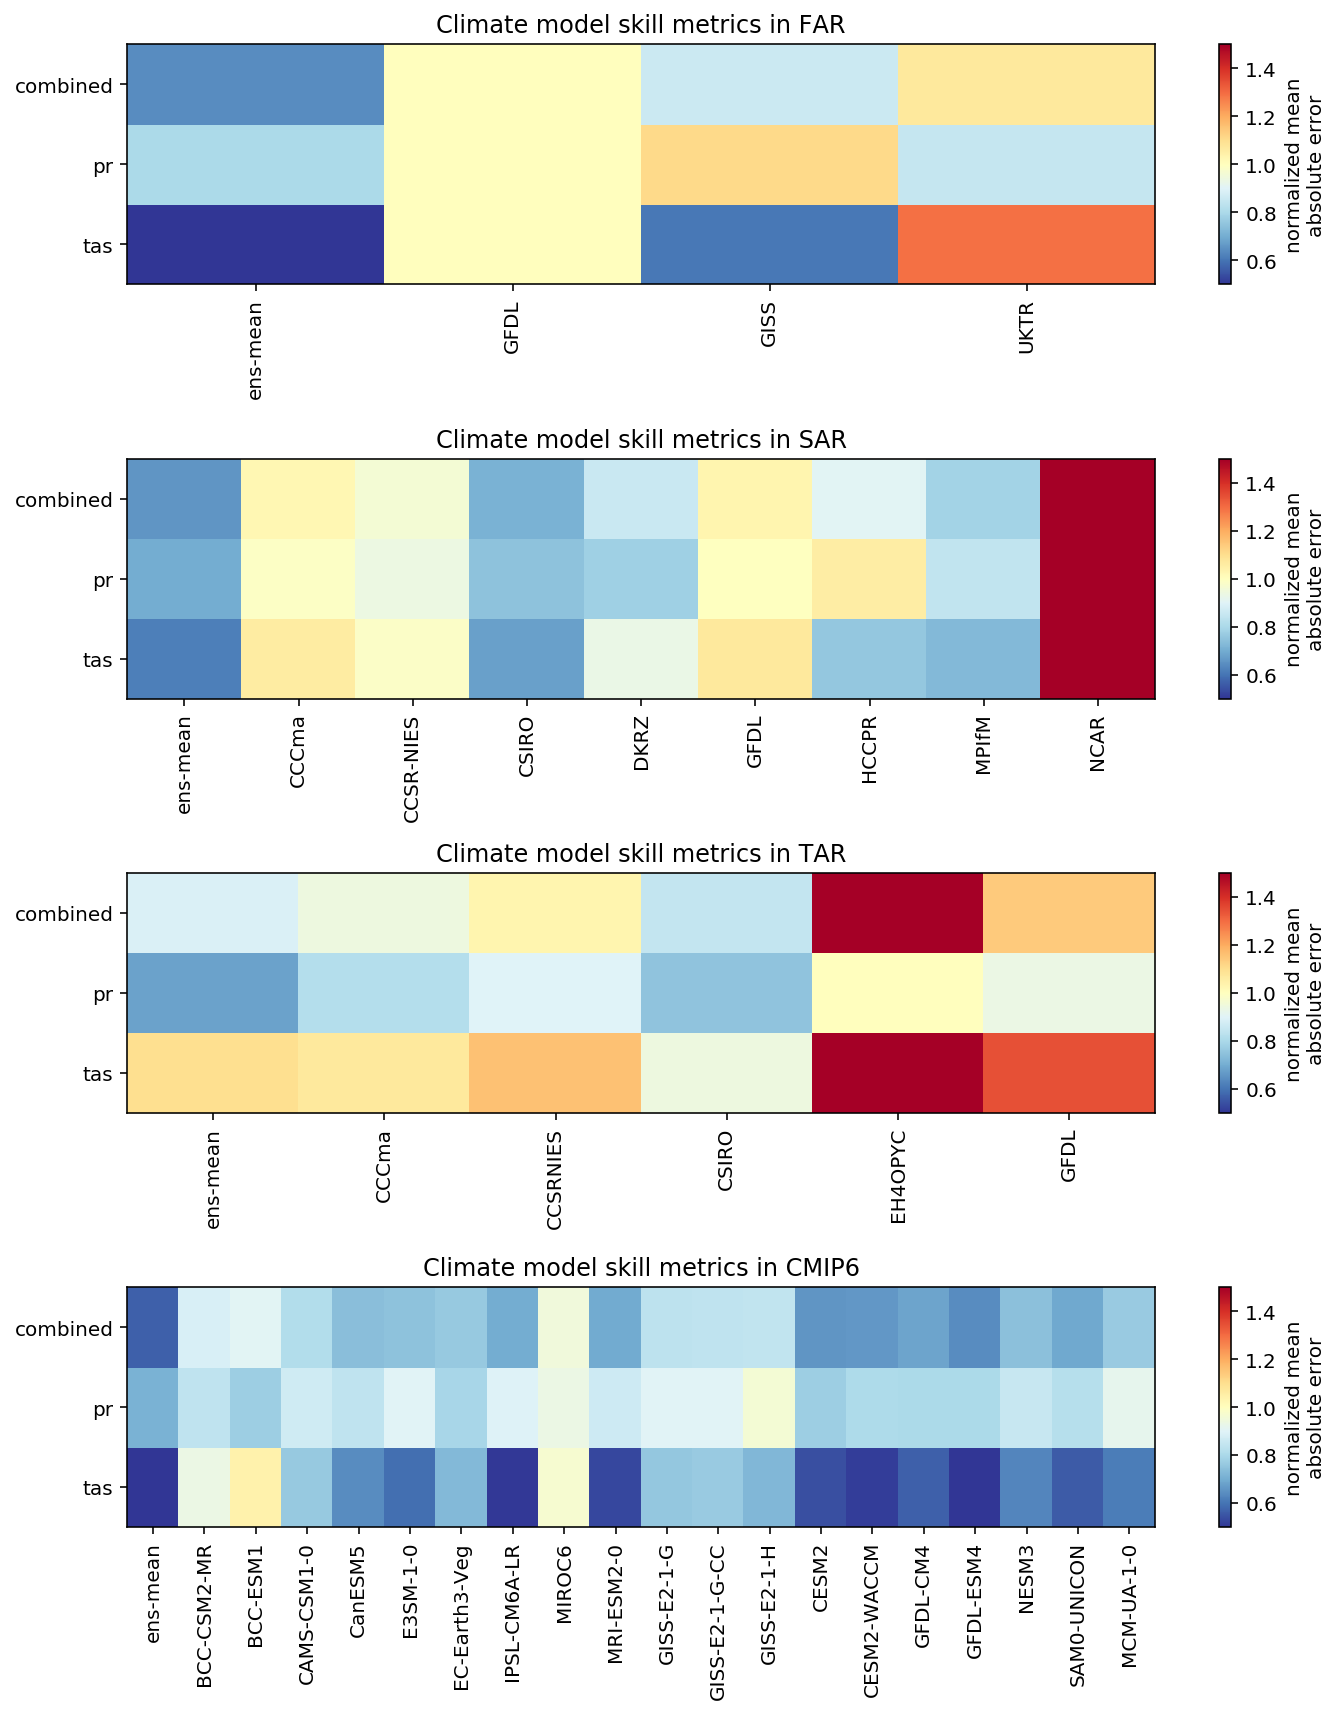

In [17]:
plt.figure(figsize=(10,12))
subplot_count = 1
for key, ens in ens_dict.items():
    plt.subplot(len(ens_dict), 1, subplot_count)
    q = carpet_plot(mae_skill_score_dict[key])
    plt.title("Climate model skill metrics in "+key)
    q.colorbar.set_label("normalized mean\nabsolute error")
    subplot_count +=1

plt.tight_layout()
plt.savefig("../figures/model_performance_over_time.png",bbox_inches='tight',dpi=100)

# Skill metrics over time

In [18]:
mip_year_dict = {'FAR': 1990,
                 'SAR': 1996,
                 'TAR': 2000,
                 'CMIP6': 2019}

mip_col = {'FAR': 'C0',
           'SAR': 'C1',
           'TAR': 'C2',
           'CMIP6': 'C3'}

var_shape = {'tas': 'o', 'pr': 's'}
var_offset = {'tas': -0.75, 'pr': 0.75}

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


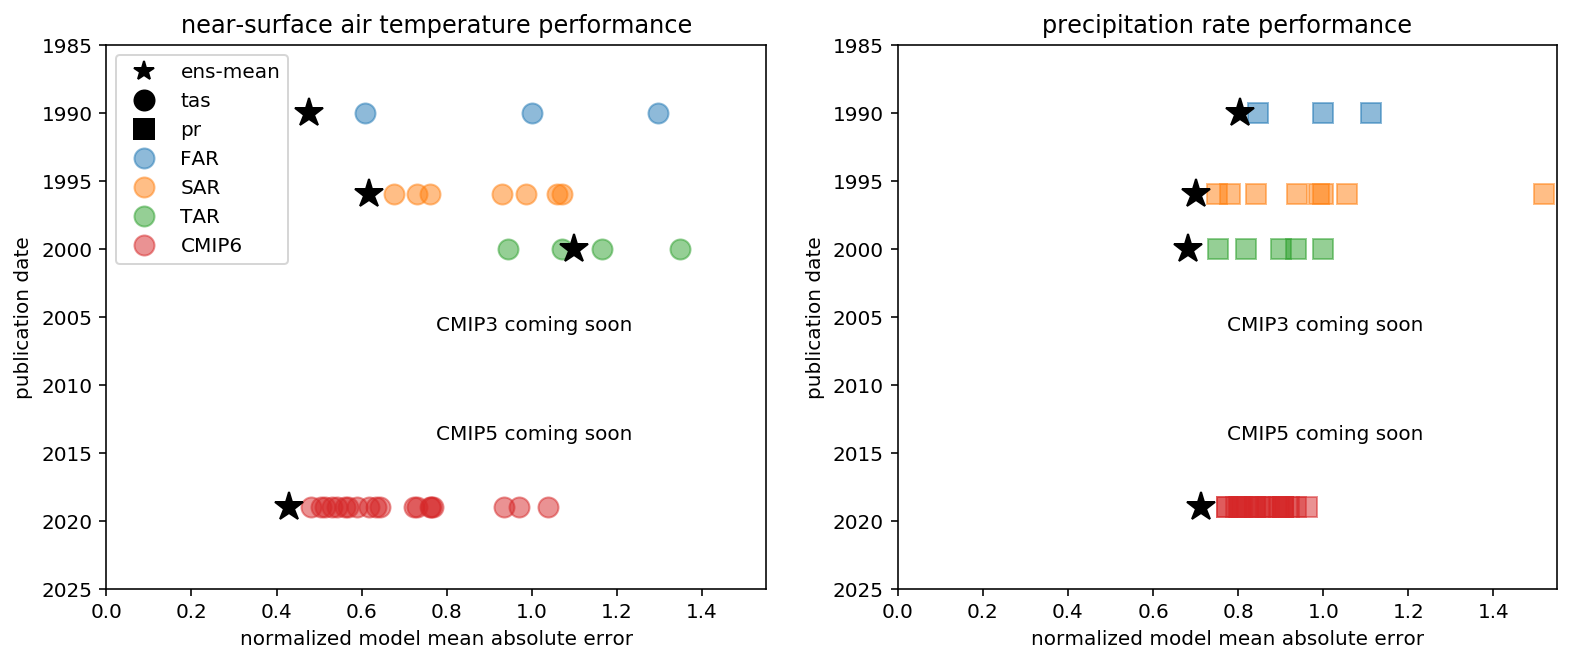

In [19]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
ens_mean_label = "ens-mean"
plt.plot([], [], 'k*', markersize=10, label=ens_mean_label)

plt.plot([], [], 'k', marker=var_shape['tas'], markersize=10, label='tas', linewidth=0.)
plt.plot([], [], 'k', marker=var_shape['pr'], markersize=10, label='pr', linewidth=0.)


for key, ens in ens_dict.items():
    
    subplot_count = 1
    for var_key in var_shape.keys():
        
        if var_key == 'tas':
            ens_label = key
        else:
            ens_label = None
            
        plt.subplot(1,2,subplot_count)
        
        not_mean_list = [key for key in ens.ensemble.values if key!='ens-mean']
        data = mae_skill_score_dict[key][var_key].sel(ensemble=not_mean_list)
        plt.plot(data,mip_year_dict[key]*np.ones_like(data),
                 var_shape[var_key], markersize=10, alpha=0.5, label=ens_label, color=mip_col[key])

        data = mae_skill_score_dict[key][var_key].sel(ensemble='ens-mean')
        plt.plot(data, mip_year_dict[key]*np.ones_like(data),
             '*', markersize=15, color='k')
        
        subplot_count+=1
    
var_longname = ['near-surface air temperature', 'precipitation rate']
for subplot_count in range(1,3):
    
    plt.subplot(1,2,subplot_count)
    plt.ylim([2025,1985])
    plt.xlim([0.,1.55])
    plt.ylabel('publication date')
    plt.xlabel('normalized model mean absolute error')
    if subplot_count == 1: plt.legend()
    plt.title(var_longname[subplot_count-1]+' performance')

    plt.text(0.775,2006,'CMIP3 coming soon')
    plt.text(0.775,2014,'CMIP5 coming soon')
    
plt.savefig("../figures/model_performance_over_time.png",bbox_inches='tight',dpi=100)

# Regional skill metrics

### Create and apply masks

In [21]:
import regionmask

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


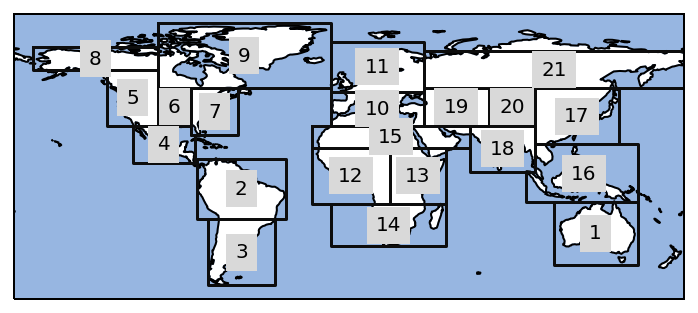

In [22]:
mask = (regionmask.defined_regions.giorgi.mask(ds_out, wrap_lon=True)
        .coarsen({'lat': coarsen_size, 'lon': coarsen_size}, boundary='exact').mean())
regionmask.defined_regions.giorgi.plot();

In [23]:
# Define mask
regional_mask = (mask==2) | (mask==3) # South America mask

# Created dictionary which holds masked mirrors of the dictionary of MIP ensembles
ens_masked_dict = {}

# loop through items in the dictionary
for key, ens in tqdm(ens_dict.items()): 
    ens_masked = ens.copy() # create a deep copy of the ensemble Dataset
    ens_masked = ens_masked.where(regional_mask) # mask model ensemble
    ens_masked_dict[key] = ens_masked # add masked ensemble to dictionary
    
obs_masked = obs.where(regional_mask) # mask observations

### Calculate skill

In [25]:
mae_masked_dict = {}
#  Now applying area weighting to this metric
for key, ens_masked in tqdm(ens_masked_dict.items()):
    mae_masked_dict[key] = xs.mae(obs_masked, ens_masked, ['lat', 'lon'], weights=area, skipna=True).compute()

In [30]:
# FAR median
mae_masked_med = mae_masked_dict['FAR'].sel(ensemble=[key for key in mae_masked_dict['FAR'].ensemble.values if key!='ens-mean']).median(dim='ensemble').compute()

mae_masked_skill_score_dict = {}
for key, ens_masked in ens_masked_dict.items():
    mae_masked = mae_masked_dict[key]
    skill_score_masked = mae_masked/mae_masked_med
    mae_masked_skill_score_dict[key] = skill_score_masked

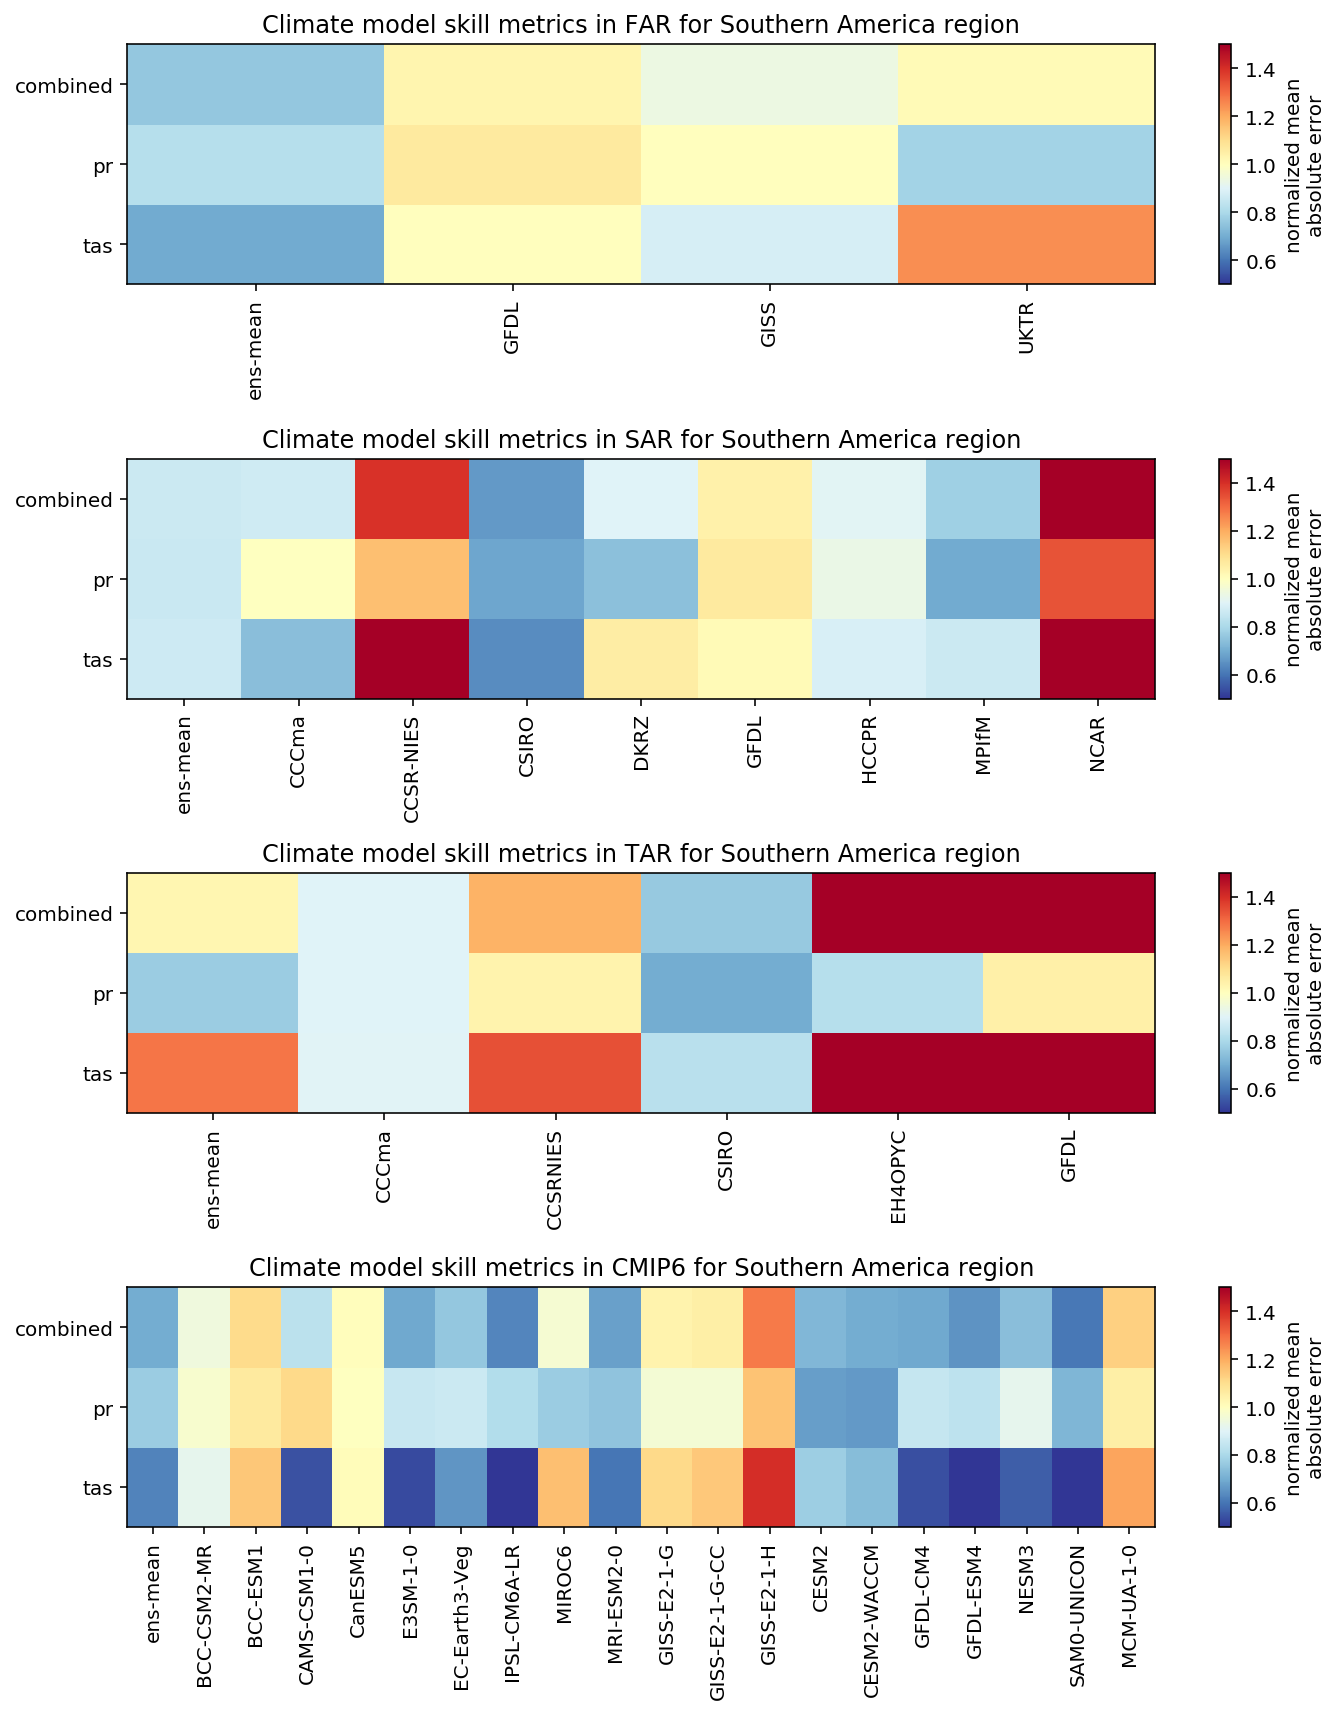

In [31]:
plt.figure(figsize=(10,12))
subplot_count = 1
for key, ens_masked in ens_masked_dict.items():
    plt.subplot(len(ens_masked_dict), 1, subplot_count)
    q = carpet_plot(mae_masked_skill_score_dict[key])
    plt.title("Climate model skill metrics in "+key+" for Southern America region")
    q.colorbar.set_label("normalized mean\nabsolute error")
    subplot_count +=1

plt.tight_layout()
plt.savefig("../figures/model_performance_over_time_South_America.png",bbox_inches='tight',dpi=100)